   # Partie2 : Réseau de neurones

Dans cette partie, le réseau de neuronnes sera entrainé pour classifier les images de la base CIFAR10.

In [ ]:

import pickle
import numpy as np
import skimage as scik
import matplotlib.pyplot as plt
import matplotlib.image as imag
import os

chemin="C:/Users/LAAJAJ/Desktop/Cours 3A/MOD3.2 Deep learning/TD1/cifar-10-batches-py/"
file_name=["batches.meta","data_batch_1","data_batch_2","data_batch_3","data_batch_4","data_batch_5","test_batch"]

def unpickle(file1):
    import pickle
    with open(file1, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


file=chemin+file_name[0]
dict_label=unpickle(file)
labels={f"{i}":dict_label[b'label_names'][i] for i in np.arange(len(dict_label[b'label_names']))}


def lecture_cifar(chemin,file_name):
    file=chemin+file_name[1]
    dict2=unpickle(file)
    X=np.array(dict2[b'data'],dtype=np.float32).reshape(10000,3072)
    Y=np.array(dict2[b'labels'],dtype=np.float32).reshape(10000,1)
    for i in np.arange(1,5):
        file=chemin+file_name[i]
        dict2=unpickle(file)
        x=np.array(dict2[b'data'],dtype=np.float32).reshape(10000,3072)   # lecture du batch numéro i
        X=np.vstack([X,x])                                               # accumulation des données des batch dans X et Y
        y=np.array(dict2[b'labels'],dtype=np.float32).reshape(10000,1)
        Y=np.vstack([Y,y])
    return X,Y


def decoupage_donnees(X,Y,app_perc,n):
    rand_n=np.random.randint(0,n,(n,1))   # generation d'un vecteur des nombres aléatoires
    # app_perc est le pourcentage des données d'apprentissage que l'on veut avoir 
    # n est le nombre des données que l'on veut
    Xapp=X[rand_n[0:int(app_perc*n/100)],:].reshape((int(app_perc*n/100),X.shape[1]))
    Yapp=Y[rand_n[0:int(app_perc*n/100)],:].reshape((int(app_perc*n/100),Y.shape[1]))
    Xtest=X[rand_n[int(app_perc*n/100):],:].reshape((n-int(app_perc*n/100),X.shape[1]))
    Ytest=Y[rand_n[int(app_perc*n/100):],:].reshape((n-int(app_perc*n/100),Y.shape[1]))
    return Xapp,Yapp,Xtest,Ytest
    
def loss_square(Y_pred,Yapp):
    return np.square(Y_pred-Yapp).sum()/2 

def loss_square_2layer(w1,w2,w3,Xapp,Yapp,b1,b2,b3,fun):
    Y_pred=predict_2layer(w1,w2,w3,Xapp,Yapp,b1,b2,b3,fun)
    return np.square(Y_pred-Yapp).sum()/2 

def activation(In,fun):  # géneralisation de la fonction d'activation
    if fun=="relu":
        Out=np.maximum(0,In)
    elif fun=="sig":
        Out=1/(1+np.exp(-In)) 
    elif fun=="leaky_relu":
        Out=np.maximum(0.1*In,In)
    return Out

def derivative(In,fun):  # géneralisation de la dérivée pour le cas de plusieurs fonctions d'activation
    if fun=="relu":
        der=In
        der[In>0]=1
        der[In<=0]=0
    elif fun=="sig":
        der=np.multiply(activation(In,fun), (1-activation(In,fun)))
    elif fun=="leaky_relu":
        der=In
        der[In>0]=1
        der[In<=0]=0.1
    return der

def loss_softmax(w1,w2,w3,Xapp,Yapp,b1,b2,b3,fun):
    Y_pred=predict_2layer(w1,w2,w3,Xapp,Yapp,b1,b2,b3,fun)
    Y_pred=np.exp(Y_pred)
    prob=Y_pred[Yapp==1]
    prob_norm=prob/(np.sum(Y_pred, axis=1))
    loss1=-np.log(prob_norm)
    return np.sum(loss1)

def loss_softmax_reg(Y_pred,Yapp):
    Y_pred=np.exp(Y_pred)
    prob=Y_pred[Yapp==1]
    prob_norm=prob/(np.sum(Y_pred, axis=1))
    loss1=-np.log(prob_norm)
    return np.sum(loss1)

def predict_2layer(w1,w2,w3,X,Y,b1,b2,b3,fun,p_regula):
    I1=X.dot(w1)+b1   #Potentiel d'entrée de la couche cachée
    O1=activation(I1,fun)*p_regula    #Sortie de la couche cachée (fonction d'activation de type sigmoïde)
    I2=O1.dot(w2)+b2      #Potentiel d'entrée de la couche de  sortie
    O2=activation(I2,fun)*p_regula       #Sortie de la couche de sortie (fonction d'activation de type sigmoïde)
    I3=O2.dot(w3)+b3
    O3=activation(I3,fun)*p_regula 
    Y_pred=O3      #Les valeurs prédites sont les sorties de la couche de sortie    
    return Y_pred
#
    
def predict_1layer(w1,w2,X,Y,b1,b2):
    I1=X.dot(w1)+b1   #Potentield'entréedelacouchecachée
    O1=1/(1+np.exp(-I1))   #Sortiedelacouchecachée(fonctiond'activationdetypesigmoïde)
    I2=O1.dot(w2)+b2      #Potentield'entréedelacouchedesortie
    O2=1/(1+np.exp(-I2))       #Sortiedelacouchedesortie(fonctiond'activationdetypesigmoïde)
    Y_pred=O2      #Lesvaleurspréditessontlessortiesdelacouchedesortie    
    return Y_pred

def evaluation_classifieur(Ytest,Ypred):
    ypred=np.argmax(Ypred,axis=1) 
    ytest=np.argmax(Ytest,axis=1) 
    accu=np.sum((ypred==ytest)) / len(Ytest)
    return accu

np.random.seed(1)


## l'entrée des données 

In [ ]:
X,Y=lecture_cifar(chemin,file_name)

y=np.zeros((np.size(Y),int(np.max(Y))+1),dtype=int)
y[np.arange(0,len(Y)),Y.astype(int).T]=1

X1app,Y1app,X1test,Y1test=decoupage_donnees(X,y,80,10000)  # 10 000 données avec 80%en apprentissage




## Visualisation des données

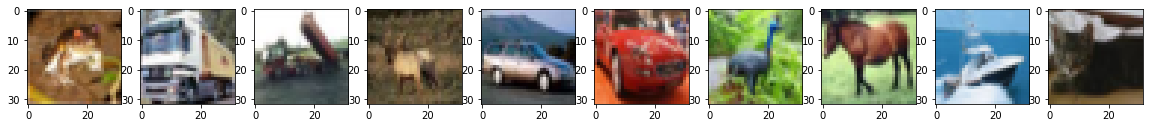

In [ ]:
plt.figure(figsize=(20,5))
for i in np.arange(10):
    
    plt.subplot(1,10,i+1)
    indice=i
    im = X[indice,:].reshape( 3072,1)/255  
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)
    img = np.dstack((im_r, im_g, im_b))
    plt.imshow(img)
plt.show() 

## l'entrainement du modèle 
### 1) le modèle avec une seule couche cachée

In [ ]:
D_in,D_h,D_out=3072,100,10
#Créationd'unematriced'entréeXetdesortieYavecdesvaleursaléatoires
#X=np.random.random((N,D_in))
#Y=np.random.random((N,D_out))
#Initialisationaléatoiredespoidsduréseau
W1=2*np.random.random((D_in,D_h))-1
b1=np.zeros((1,D_h))
W2=2*np.random.random((D_h,D_out))-1
b2=np.zeros((1,D_out))

lrate=1*10**-4
N_epoch=1000
accuracy_test=np.zeros((N_epoch))
accuracy_app=np.zeros((N_epoch))
loss_test=np.zeros((N_epoch))
loss_app=np.zeros((N_epoch))
for n in np.arange(0,N_epoch):
    I1=X1app.dot(W1)+b1   #Potentield'entréedelacouchecachée
    O1=1/(1+np.exp(-I1))   #Sortiedelacouchecachée(fonctiond'activationdetypesigmoïde)
    I2=O1.dot(W2)+b2      #Potentield'entréedelacouchedesortie
    O2=1/(1+np.exp(-I2))       #Sortiedelacouchedesortie(fonctiond'activationdetypesigmoïde)
    Y_pred=O2      #Les valeurs prédites sont les sorties de la couche de sortie
    
    #grad_loss_I2=(O2-Y1app)   #.dot(derivative(I2))  # eta3
    #grad_loss_I1=grad_loss_I2.dot(W1.T)*derivative(I1).T  # eta3
    
    grad_loss_O2=(O2-Y1app)   #.dot(derivative(I2))  # eta3
    grad_loss_I2=np.multiply(grad_loss_O2,derivative(I2,"sig"))
    #grad_loss_I2=((1-O2)*O2)*grad_loss_O2
    grad_loss_w2=(O1.T).dot(grad_loss_I2)
    grad_loss_b2=np.sum(grad_loss_I2,axis=0)
    
    grad_loss_O1=grad_loss_I2.dot(W2.T)     # eta3
    grad_loss_I1=np.multiply(grad_loss_O1,derivative(I1,"sig"))
    #grad_loss_I1=((1-O1)*O1)*grad_loss_O1
    grad_loss_w1=(X1app.T).dot(grad_loss_I1)
    grad_loss_b1=np.sum(grad_loss_I1,axis=0)
    
    W1=W1 -lrate*grad_loss_w1
    W2=W2 -lrate*grad_loss_w2
    b1=b1 -lrate*grad_loss_b1
    b2=b2 -lrate*grad_loss_b2
    
    Y_pred_test=predict_1layer(W1,W2,X1test,Y1test,b1,b2)
    accuracy_test[n]=evaluation_classifieur(Y1test,Y_pred_test)
    Y_pred_app=predict_1layer(W1,W2,X1app,Y1app,b1,b2)
    accuracy_app[n]=evaluation_classifieur(Y1app,Y_pred_app)
    loss_test[n]=np.square(Y_pred_test-Y1test).sum()/2
    loss_app[n]=np.square(Y_pred_app-Y1app).sum()/2




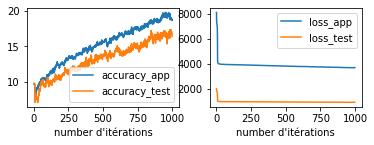

In [ ]:
plt.subplot(221)
plt.plot(np.arange(0,N_epoch),accuracy_app*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.subplot(222)
plt.plot(np.arange(0,N_epoch),loss_app,label="loss_app")
plt.plot(np.arange(0,N_epoch),loss_test,label="loss_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.show()

L'algoritme apprend très bien puique le taux de clasification augmente en fonction des itérations. Mais l'apprentissage demende beaucoup de temps (quelques heures) pour bien entrainer le modèle. Pour cela il faut faire beaucoup d'itération jusqu'à ce que le taux de classification pour les données de test commence à descendre.

## Modification du nombre de neurones de la couche cachée


In [ ]:
Dh_value=np.array([50,100,200,300])
accuracy_test=np.zeros((N_epoch,len(Dh_value)))
accuracy_app=np.zeros((N_epoch,len(Dh_value)))
loss_test=np.zeros((N_epoch,len(Dh_value)))
loss_app=np.zeros((N_epoch,len(Dh_value)))


D_in,D_h,D_out=3072,Dh_value[i],10

#Initialisation aléatoire des poids du réseau
W1=2*np.random.random((D_in,D_h))-1
b1=np.zeros((1,D_h))
W2=2*np.random.random((D_h,D_out))-1
b2=np.zeros((1,D_out))

lrate=1*10**-4
N_epoch=50

for n in np.arange(0,N_epoch):
    I1=X1app.dot(W1)+b1   #Potentield'entréedelacouchecachée
    O1=1/(1+np.exp(-I1))   #Sortiedelacouchecachée(fonctiond'activationdetypesigmoïde)
    I2=O1.dot(W2)+b2      #Potentield'entréedelacouchedesortie
    O2=1/(1+np.exp(-I2))       #Sortiedelacouchedesortie(fonctiond'activationdetypesigmoïde)
    Y_pred=O2      #Les valeurs prédites sont les sorties de la couche de sortie

    grad_loss_O2=(O2-Y1app)   #.dot(derivative(I2))  # eta3
    grad_loss_I2=np.multiply(grad_loss_O2,derivative(I2,"sig"))
    #grad_loss_I2=((1-O2)*O2)*grad_loss_O2
    grad_loss_w2=(O1.T).dot(grad_loss_I2)
    grad_loss_b2=np.sum(grad_loss_I2,axis=0)

    grad_loss_O1=grad_loss_I2.dot(W2.T)     # eta3
    grad_loss_I1=np.multiply(grad_loss_O1,derivative(I1,"sig"))
    #grad_loss_I1=((1-O1)*O1)*grad_loss_O1
    grad_loss_w1=(X1app.T).dot(grad_loss_I1)
    grad_loss_b1=np.sum(grad_loss_I1,axis=0)

    W1=W1 -lrate*grad_loss_w1
    W2=W2 -lrate*grad_loss_w2
    b1=b1 -lrate*grad_loss_b1
    b2=b2 -lrate*grad_loss_b2

    Y_pred_test=predict_1layer(W1,W2,X1test,Y1test,b1,b2)
    accuracy_test[n,i]=evaluation_classifieur(Y1test,Y_pred_test)
    Y_pred_app=predict_1layer(W1,W2,X1app,Y1app,b1,b2)
    accuracy_app[n,i]=evaluation_classifieur(Y1app,Y_pred_app)
    loss_test[n,i]=np.square(Y_pred_test-Y1test).sum()/2
    loss_app[n,i]=np.square(Y_pred_app-Y1app).sum()/2



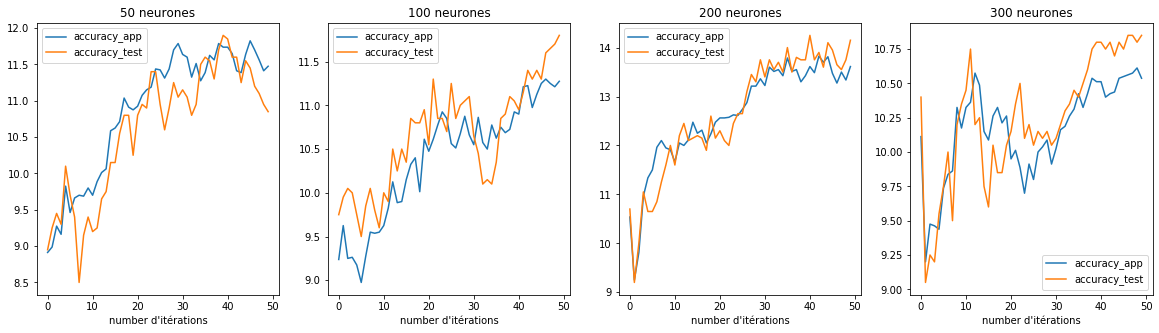

In [ ]:
figure=plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(np.arange(0,N_epoch),accuracy_app[0:N_epoch,0]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test[0:N_epoch,0]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("50 neurones")
plt.legend()
plt.subplot(142)
plt.plot(np.arange(0,N_epoch),accuracy_app[0:N_epoch,1]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test[0:N_epoch,1]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("100 neurones")
plt.legend()
plt.subplot(143)
plt.plot(np.arange(0,N_epoch),accuracy_app[0:N_epoch,2]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test[0:N_epoch,2]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("200 neurones")
plt.legend()
plt.subplot(144)
plt.plot(np.arange(0,N_epoch),accuracy_app[0:N_epoch,3]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test[0:N_epoch,3]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("300 neurones")
plt.legend()
plt.show()

On peut constater que plus le nombre de neurones dans la couche cachée est élevé, plus le taux de classification augmente rapidement. L'augmentation de nombre de neurones fait que le deux courbes de taux de classification pour l'apprentissage et le test se rapprochent, ce qui veut dire que l'algoritme sous-apprends (underfiting) pendant les premières itérations.

## Ajout d'une couche dans le réseau de neurones

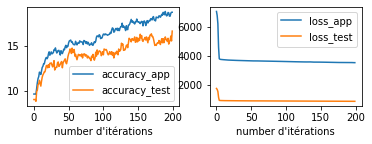

In [ ]:
D_in,D_h,D_h2,D_out=3072,100,50,10
#Créationd'unematriced'entréeXetdesortieYavecdesvaleursaléatoires
#X=np.random.random((N,D_in))
#Y=np.random.random((N,D_out))
#Initialisationaléatoiredespoidsduréseau
W1=2*np.random.random((D_in,D_h))-1
b1=np.zeros((1,D_h))
W2=2*np.random.random((D_h,D_h2))-1
b2=np.zeros((1,D_h2))
W3=2*np.random.random((D_h2,D_out))-1
b3=np.zeros((1,D_out))

func='sig'
lrate=1*10**-4
N_epoch=200
accuracy_test=np.zeros((N_epoch))
accuracy_app=np.zeros((N_epoch))
loss_test=np.zeros((N_epoch))
loss_app=np.zeros((N_epoch))
for n in np.arange(0,N_epoch):
    I1=X1app.dot(W1)+b1   #Potentield'entréedelacouchecachée
    O1=activation(I1,func)   #Sortiedelacouchecachée(fonctiond'activationdetypesigmoïde)
    I2=O1.dot(W2)+b2      #Potentield'entréedelacouchedesortie
    O2=activation(I2,func)       #Sortiedelacouchedesortie(fonctiond'activationdetypesigmoïde)
    I3=O2.dot(W3)+b3
    O3=activation(I3,func)
    Y_pred=O3      #Les valeurs prédites sont les sorties de la couche de sortie
    
    #grad_loss_I2=(O2-Y1app)   #.dot(derivative(I2))  # eta3
    #grad_loss_I1=grad_loss_I2.dot(W1.T)*derivative(I1).T  # eta3
    grad_loss_O3=(O3-Y1app)   #.dot(derivative(I2))  # eta3
    grad_loss_I3=np.multiply(grad_loss_O3,derivative(I3,func))
    grad_loss_w3=(O2.T).dot(grad_loss_I3)
    grad_loss_b3=np.sum(grad_loss_I3,axis=0)
    
    grad_loss_O2=grad_loss_I3.dot(W3.T)     
    grad_loss_I2=np.multiply(grad_loss_O2,derivative(I2,func))
    grad_loss_w2=(O1.T).dot(grad_loss_I2)
    grad_loss_b2=np.sum(grad_loss_I2,axis=0)
    
    grad_loss_O1=grad_loss_I2.dot(W2.T)     # eta3
    grad_loss_I1=np.multiply(grad_loss_O1,derivative(I1,func))
    grad_loss_w1=(X1app.T).dot(grad_loss_I1)
    grad_loss_b1=np.sum(grad_loss_I1,axis=0)
    
    W1=W1 -lrate*grad_loss_w1
    W2=W2 -lrate*grad_loss_w2
    W3=W3 -lrate*grad_loss_w3
    
    b1=b1 -lrate*grad_loss_b1
    b2=b2 -lrate*grad_loss_b2
    b3=b3 -lrate*grad_loss_b3
    
    Y_pred_test=predict_2layer(W1,W2,W3,X1test,Y1test,b1,b2,b3,func)
    accuracy_test[n]=evaluation_classifieur(Y1test,Y_pred_test)
    Y_pred_app=predict_2layer(W1,W2,W3,X1app,Y1app,b1,b2,b3,func)
    accuracy_app[n]=evaluation_classifieur(Y1app,Y_pred_app)
    loss_test[n]=loss_square_2layer(W1,W2,W3,X1test,Y1test,b1,b2,b3,func)
    loss_app[n]=loss_square_2layer(W1,W2,W3,X1app,Y1app,b1,b2,b3,func)
  #  loss_test[n]=loss_softmax(W1,W2,W3,X1test,Y1test,b1,b2,b3,func)
 #   loss_app[n]=loss_softmax(W1,W2,W3,X1app,Y1app,b1,b2,func)
    
plt.subplot(221)
plt.plot(np.arange(0,N_epoch),accuracy_app*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.subplot(222)
plt.plot(np.arange(0,N_epoch),loss_app,label="loss_app")
plt.plot(np.arange(0,N_epoch),loss_test,label="loss_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.show()

L'ajout d'une couche dans notre réseau a augmenté le taux de clasification par rapport à la configuration de réseau précedent.

## Introduire la régularisation 


### Régularisation de type Dropout
Nous allons utiliser la régularisationde type 'Dropout' qui consiste à désactiver certains neurones dans les couches du réseau

In [ ]:
D_in,D_h,D_h2,D_out=3072,100,50,10
#Créationd'unematriced'entréeXetdesortieYavecdesvaleursaléatoires
#X=np.random.random((N,D_in))
#Y=np.random.random((N,D_out))
#Initialisationaléatoiredespoidsduréseau
W1=2*np.random.random((D_in,D_h))-1
b1=np.zeros((1,D_h))
W2=2*np.random.random((D_h,D_h2))-1
b2=np.zeros((1,D_h2))
W3=2*np.random.random((D_h2,D_out))-1
b3=np.zeros((1,D_out))

p=0.8 # la probabilité qu'un neurone soit activé 
func='sig'
lrate=1*10**-4
N_epoch=200
accuracy_test=np.zeros((N_epoch))
accuracy_app=np.zeros((N_epoch))
loss_test=np.zeros((N_epoch))
loss_app=np.zeros((N_epoch))
for n in np.arange(0,N_epoch):
    I1=X1app.dot(W1)+b1   #Potentiel d'entrée de la couche cachée
    O1=activation(I1,func)   #Sortie de la couche cachée(fonction d'activation de type sigmoïde)
    U1=np.random.rand(*O1.shape)<p  # premier mask pour désactiver certaines neurones de cette couche
    O1=O1*U1     # application du mask
    
    I2=O1.dot(W2)+b2      #Potentiel d'entrée de la couche de sortie
    O2=activation(I2,func)       #Sortie de la couche de sortie(fonction d'activation de type sigmoïde)
    U2=np.random.rand(*O2.shape)<p 
    O2=O2*U2
    
    I3=O2.dot(W3)+b3
    O3=activation(I3,func)
    U3=np.random.rand(*O3.shape)<p 
    O3=O3*U3
    Y_pred=O3      #Les valeurs prédites sont les sorties de la couche de sortie
    
    Y_pred_test=predict_2layer(W1,W2,W3,X1test,Y1test,b1,b2,b3,func,p)  # multiplication des couches par p pour avoir le meme Output que pour les données d'apprentissage
    Y_pred_app=Y_pred  #predict_2layer(W1,W2,W3,X1app,Y1app,b1,b2,b3,func)
    
    #grad_loss_I2=(O2-Y1app)   #.dot(derivative(I2))  # eta3
    #grad_loss_I1=grad_loss_I2.dot(W1.T)*derivative(I1).T  # eta3
    grad_loss_O3=(O3-Y1app)   #.dot(derivative(I2))  # eta3
    grad_loss_I3=np.multiply(grad_loss_O3,derivative(I3,func))
    grad_loss_w3=(O2.T).dot(grad_loss_I3)
    grad_loss_b3=np.sum(grad_loss_I3,axis=0)
    
    grad_loss_O2=grad_loss_I3.dot(W3.T)     
    grad_loss_I2=np.multiply(grad_loss_O2,derivative(I2,func))
    grad_loss_w2=(O1.T).dot(grad_loss_I2)
    grad_loss_b2=np.sum(grad_loss_I2,axis=0)
    
    grad_loss_O1=grad_loss_I2.dot(W2.T)     # eta3
    grad_loss_I1=np.multiply(grad_loss_O1,derivative(I1,func))
    grad_loss_w1=(X1app.T).dot(grad_loss_I1)
    grad_loss_b1=np.sum(grad_loss_I1,axis=0)
    
    W1=W1 -lrate*grad_loss_w1
    W2=W2 -lrate*grad_loss_w2
    W3=W3 -lrate*grad_loss_w3
    
    b1=b1 -lrate*grad_loss_b1
    b2=b2 -lrate*grad_loss_b2
    b3=b3 -lrate*grad_loss_b3
    
    
    accuracy_test[n]=evaluation_classifieur(Y1test,Y_pred_test)
    accuracy_app[n]=evaluation_classifieur(Y1app,Y_pred_app)
    
    loss_test[n]=loss_softmax_reg(Y_pred_test,Y1test)
    loss_app[n]=loss_softmax_reg(Y_pred_app,Y1app)
    


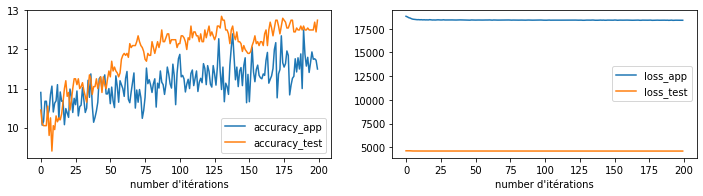

In [ ]:
figure4=plt.figure(figsize=(12,6))
plt.subplot(221)
plt.plot(np.arange(0,N_epoch),accuracy_app*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.subplot(222)
plt.plot(np.arange(0,N_epoch),loss_app,label="loss_app")
plt.plot(np.arange(0,N_epoch),loss_test,label="loss_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.show()

La régularisation ralentit l'apprentissage et cela est tout à fait normal car le paramètre de probabilité qu'un neurone soit activé est 0.2. Donc l'algoritme fonctionne avec moins de paramètres et cela permet d'éviter le sur_apprentissage.

## Variation de taux d'apprentissage

In [ ]:


D_in,D_h,D_h2,D_out=3072,100,50,10
#Créationd'unematriced'entréeXetdesortieYavecdesvaleursaléatoires
#X=np.random.random((N,D_in))
#Y=np.random.random((N,D_out))
#Initialisationaléatoiredespoidsduréseau
W1=2*np.random.random((D_in,D_h))-1
b1=np.zeros((1,D_h))
W2=2*np.random.random((D_h,D_h2))-1
b2=np.zeros((1,D_h2))
W3=2*np.random.random((D_h2,D_out))-1
b3=np.zeros((1,D_out))

Learn_rate=np.array([0.0001,0.001,1,10])

accuracy_test=np.zeros((N_epoch,len(Learn_rate)))
accuracy_app=np.zeros((N_epoch,len(Learn_rate)))
loss_test=np.zeros((N_epoch,len(Learn_rate)))
loss_app=np.zeros((N_epoch,len(Learn_rate)))

for i in np.arange(len(Learn_rate)):
    func='sig'
    lrate=Learn_rate[i]    # boucle sur le taux d'apprentissage
    N_epoch=200
    
    for n in np.arange(0,N_epoch):
        I1=X1app.dot(W1)+b1   #Potentield'entréedelacouchecachée
        O1=activation(I1,func)   #Sortiedelacouchecachée(fonctiond'activationdetypesigmoïde)
        I2=O1.dot(W2)+b2      #Potentield'entréedelacouchedesortie
        O2=activation(I2,func)       #Sortiedelacouchedesortie(fonctiond'activationdetypesigmoïde)
        I3=O2.dot(W3)+b3
        O3=activation(I3,func)
        Y_pred=O3      #Les valeurs prédites sont les sorties de la couche de sortie

        Y_pred_test=predict_2layer(W1,W2,W3,X1test,Y1test,b1,b2,b3,func,1)
        Y_pred_app=Y_pred #predict_2layer(W1,W2,W3,X1app,Y1app,b1,b2,b3,func)

        grad_loss_O3=(O3-Y1app)   #.dot(derivative(I2))  # eta3
        grad_loss_I3=np.multiply(grad_loss_O3,derivative(I3,func))
        grad_loss_w3=(O2.T).dot(grad_loss_I3)
        grad_loss_b3=np.sum(grad_loss_I3,axis=0)

        grad_loss_O2=grad_loss_I3.dot(W3.T)     
        grad_loss_I2=np.multiply(grad_loss_O2,derivative(I2,func))
        grad_loss_w2=(O1.T).dot(grad_loss_I2)
        grad_loss_b2=np.sum(grad_loss_I2,axis=0)

        grad_loss_O1=grad_loss_I2.dot(W2.T)     # eta3
        grad_loss_I1=np.multiply(grad_loss_O1,derivative(I1,func))
        grad_loss_w1=(X1app.T).dot(grad_loss_I1)
        grad_loss_b1=np.sum(grad_loss_I1,axis=0)

        W1=W1 -lrate*grad_loss_w1
        W2=W2 -lrate*grad_loss_w2
        W3=W3 -lrate*grad_loss_w3

        b1=b1 -lrate*grad_loss_b1
        b2=b2 -lrate*grad_loss_b2
        b3=b3 -lrate*grad_loss_b3

        accuracy_test[n,i]=evaluation_classifieur(Y1test,Y_pred_test)
        accuracy_app[n,i]=evaluation_classifieur(Y1app,Y_pred_app)

        loss_test[n,i]=loss_square(Y1test,Y_pred_test)
        loss_app[n,i]=loss_square(Y1app,Y_pred_app)


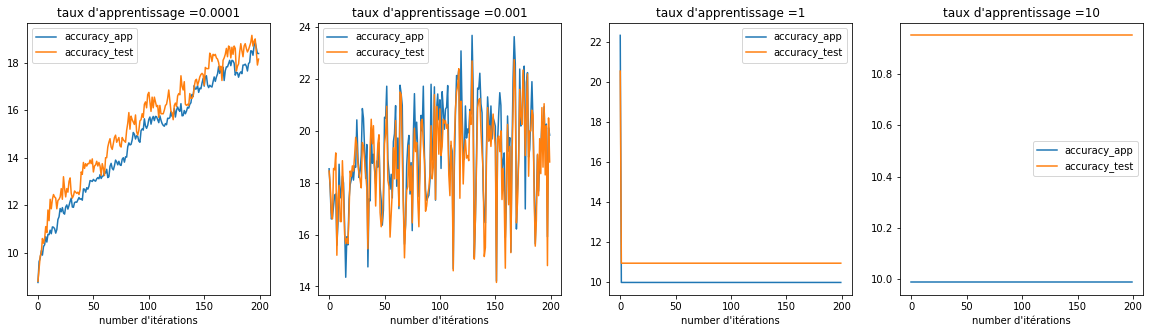

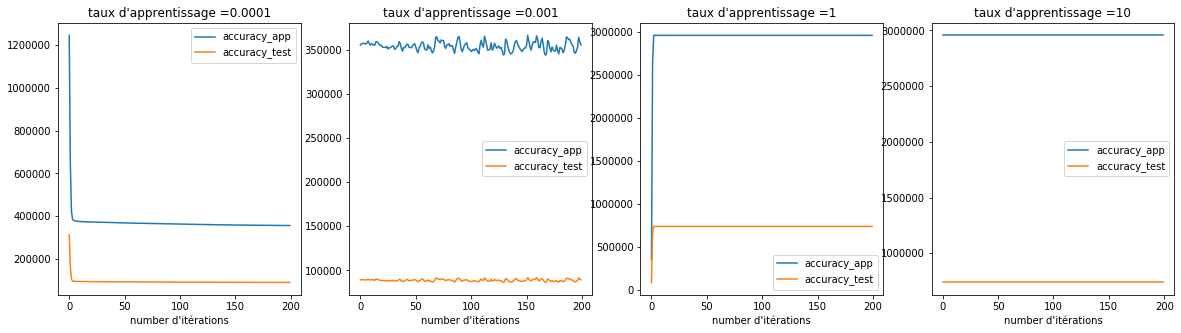

In [ ]:
figure=plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(np.arange(0,N_epoch),accuracy_app[0:N_epoch,0]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test[0:N_epoch,0]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("taux d'apprentissage =0.0001")
plt.legend()
plt.subplot(142)
plt.plot(np.arange(0,N_epoch),accuracy_app[0:N_epoch,1]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test[0:N_epoch,1]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("taux d'apprentissage =0.001")
plt.legend()
plt.subplot(143)
plt.plot(np.arange(0,N_epoch),accuracy_app[0:N_epoch,2]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test[0:N_epoch,2]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("taux d'apprentissage =1")
plt.legend()
plt.subplot(144)
plt.plot(np.arange(0,N_epoch),accuracy_app[0:N_epoch,3]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test[0:N_epoch,3]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("taux d'apprentissage =10")
plt.legend()
plt.show()

figure2=plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(np.arange(0,N_epoch),loss_app[0:N_epoch,0]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),loss_test[0:N_epoch,0]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("taux d'apprentissage =0.0001")
plt.legend()
plt.subplot(142)
plt.plot(np.arange(0,N_epoch),loss_app[0:N_epoch,1]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),loss_test[0:N_epoch,1]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("taux d'apprentissage =0.001")
plt.legend()
plt.subplot(143)
plt.plot(np.arange(0,N_epoch),loss_app[0:N_epoch,2]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),loss_test[0:N_epoch,2]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("taux d'apprentissage =1")
plt.legend()
plt.subplot(144)
plt.plot(np.arange(0,N_epoch),loss_app[0:N_epoch,3]*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),loss_test[0:N_epoch,3]*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.title("taux d'apprentissage =10")
plt.legend()
plt.show()

Pour un taux d'apprentissage de 0.0001 l'algorithme de gradient de descent converge lentement et la fonction de perte diminue lentement. Par contre pour un taux de 0.001 l'algoritme se déplace rapidement autour du minimum de la fonction perte mais il oscille autour du minimum et ne se stabilise pas. Donc le meilleur taux d'apprentissage est 10^-4 

## Utilisation des mini-batch pour la descente du gradient

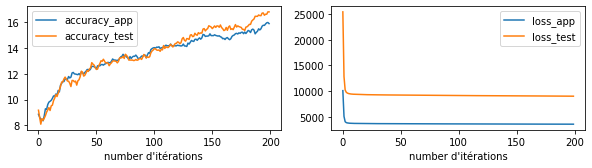

In [ ]:

D_in,D_h,D_h2,D_out=3072,100,50,10
W1=2*np.random.random((D_in,D_h))-1
b1=np.zeros((1,D_h))
W2=2*np.random.random((D_h,D_h2))-1
b2=np.zeros((1,D_h2))
W3=2*np.random.random((D_h2,D_out))-1
b3=np.zeros((1,D_out))

func='sig'
lrate=0.0001
N_epoch=200

accuracy_test=np.zeros((N_epoch))
accuracy_app=np.zeros((N_epoch))
loss_test=np.zeros((N_epoch))
loss_app=np.zeros((N_epoch))
N_batch=10
N=X1app.shape[0]

for n in np.arange(0,N_epoch):
    accuracy_test_mini_batch=np.zeros((N_batch))
    accuracy_app_mini_batch=np.zeros((N_batch))
    loss_test_mini_batch=np.zeros((N_batch))
    loss_app_mini_batch=np.zeros((N_batch))
    
    for i in np.arange(N_batch):
        debut=int(N/N_batch*i)      # indice de début de répartition des données d'apprentissage
        fin=int(N/N_batch*i)+int(N/N_batch)   # indice de fin de répartition des données d'apprentissage
        X1app_mini=X1app[debut:fin,:]    # création du mini-batch d'apprentissage
        Y1app_mini=Y1app[debut:fin,:] 
        I1=X1app_mini.dot(W1)+b1   # Potentiel d'entrée de la couche cachée
        O1=activation(I1,func)   #Sortie de la couche cachée( fonction d'activation de type sigmoïde)
        I2=O1.dot(W2)+b2      
        O2=activation(I2,func)       
        I3=O2.dot(W3)+b3
        O3=activation(I3,func)
        Y_pred=O3      #Les valeurs prédites sont les sorties de la couche de sortie

        Y_pred_test=predict_2layer(W1,W2,W3,X1test,Y1test,b1,b2,b3,func,1)    # les données de test restent comme avant
        Y_pred_app=Y_pred 
        
        grad_loss_O3=(O3-Y1app_mini)   
        grad_loss_I3=np.multiply(grad_loss_O3,derivative(I3,func))
        grad_loss_w3=(O2.T).dot(grad_loss_I3)
        grad_loss_b3=np.sum(grad_loss_I3,axis=0)

        grad_loss_O2=grad_loss_I3.dot(W3.T)     
        grad_loss_I2=np.multiply(grad_loss_O2,derivative(I2,func))
        grad_loss_w2=(O1.T).dot(grad_loss_I2)
        grad_loss_b2=np.sum(grad_loss_I2,axis=0)

        grad_loss_O1=grad_loss_I2.dot(W2.T)     
        grad_loss_I1=np.multiply(grad_loss_O1,derivative(I1,func))
        grad_loss_w1=(X1app_mini.T).dot(grad_loss_I1)
        grad_loss_b1=np.sum(grad_loss_I1,axis=0)

        W1=W1 -lrate*grad_loss_w1   # mise à jour des paramètres après chaque itération sur un mini-batch
        W2=W2 -lrate*grad_loss_w2
        W3=W3 -lrate*grad_loss_w3

        b1=b1 -lrate*grad_loss_b1
        b2=b2 -lrate*grad_loss_b2
        b3=b3 -lrate*grad_loss_b3
        
        accuracy_test_mini_batch[i]=evaluation_classifieur(Y1test,Y_pred_test)
        accuracy_app_mini_batch[i]=evaluation_classifieur(Y1app_mini,Y_pred_app)
        loss_test_mini_batch[i]=loss_square(Y1test,Y_pred_test)
        loss_app_mini_batch[i]=loss_square(Y1app_mini,Y_pred_app)

    accuracy_test[n]=np.mean(accuracy_test_mini_batch)
    accuracy_app[n]=np.mean(accuracy_app_mini_batch)
    loss_test[n]=np.sum(loss_test_mini_batch)
    loss_app[n]=np.sum(loss_app_mini_batch)

figure=plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(np.arange(0,N_epoch),accuracy_app*100,label="accuracy_app")
plt.plot(np.arange(0,N_epoch),accuracy_test*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.subplot(222)
plt.plot(np.arange(0,N_epoch),loss_app,label="loss_app")
plt.plot(np.arange(0,N_epoch),loss_test,label="loss_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.show()
evaluation_mini_batch={"accu_test":accuracy_test,"accu_app":accuracy_app, "loss_test":loss_test,"loss_app":loss_app}

Le taux de classification pour les données de test est un peu élevé par rapport à la Partie (Ajout d'une couche dans le réseau de neurones) puisque à chaque itération, la mise à jour des paramètres du modèle se fait 10 fois (le nombre des mini-batch). On constate aussi une légère diminution de ce taux pour les données d'apprentissage, car l'algoritme apprend sur moins de données (mini-batch). 


   ## Validation croisée à N répertoires

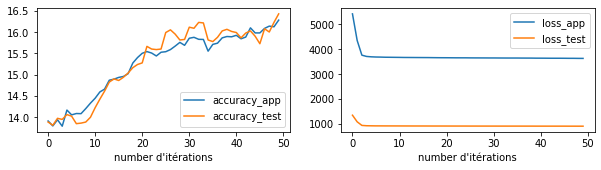

In [ ]:

D_in,D_h,D_h2,D_out=3072,100,50,10
W1=2*np.random.random((D_in,D_h))-1
b1=np.zeros((1,D_h))
W2=2*np.random.random((D_h,D_h2))-1
b2=np.zeros((1,D_h2))
W3=2*np.random.random((D_h2,D_out))-1
b3=np.zeros((1,D_out))

func='sig'
lrate=0.0001
N_epoch=50
N_fold=4
N=X1app.shape[0]

accuracy_test_kfold=np.zeros((N_epoch,N_fold))
accuracy_app_kfold=np.zeros((N_epoch,N_fold))
loss_test_kfold=np.zeros((N_epoch,N_fold))
loss_app_kfold=np.zeros((N_epoch,N_fold))
    
for i in np.arange(N_fold):
    debut=int(N/N_fold*i)      # indice de début de répartition des données d'apprentissage
    fin=int(N/N_fold*i)+int(N/N_fold)   # indice de fin de répartition des données d'apprentissage
    X1app_fold=np.concatenate((X1app[0:debut,:],X1app[debut:,:]),axis=0)    
    Y1app_fold=np.concatenate((Y1app[0:debut,:],Y1app[debut:,:]),axis=0)  
    X1test_fold=X1app[debut:fin,:]    
    Y1test_fold=Y1app[debut:fin,:]     
        
    for n in np.arange(0,N_epoch):

        I1=X1app_fold.dot(W1)+b1   # Potentiel d'entrée de la couche cachée
        O1=activation(I1,func)   #Sortie de la couche cachée( fonction d'activation de type sigmoïde)
        I2=O1.dot(W2)+b2      
        O2=activation(I2,func)       
        I3=O2.dot(W3)+b3
        O3=activation(I3,func)
        Y_pred=O3      #Les valeurs prédites sont les sorties de la couche de sortie

        Y_pred_test=predict_2layer(W1,W2,W3,X1test_fold,Y1test_fold,b1,b2,b3,func,1)    # les données de test restent comme avant
        Y_pred_app=Y_pred 

        grad_loss_O3=(O3-Y1app_fold)   
        grad_loss_I3=np.multiply(grad_loss_O3,derivative(I3,func))
        grad_loss_w3=(O2.T).dot(grad_loss_I3)
        grad_loss_b3=np.sum(grad_loss_I3,axis=0)

        grad_loss_O2=grad_loss_I3.dot(W3.T)     
        grad_loss_I2=np.multiply(grad_loss_O2,derivative(I2,func))
        grad_loss_w2=(O1.T).dot(grad_loss_I2)
        grad_loss_b2=np.sum(grad_loss_I2,axis=0)

        grad_loss_O1=grad_loss_I2.dot(W2.T)     
        grad_loss_I1=np.multiply(grad_loss_O1,derivative(I1,func))
        grad_loss_w1=(X1app_fold.T).dot(grad_loss_I1)
        grad_loss_b1=np.sum(grad_loss_I1,axis=0)

        W1=W1 -lrate*grad_loss_w1   # mise à jour des paramètres après chaque itération sur un mini-batch
        W2=W2 -lrate*grad_loss_w2
        W3=W3 -lrate*grad_loss_w3

        b1=b1 -lrate*grad_loss_b1
        b2=b2 -lrate*grad_loss_b2
        b3=b3 -lrate*grad_loss_b3

        accuracy_test_kfold[n,i]=evaluation_classifieur(Y1test_fold,Y_pred_test)
        accuracy_app_kfold[n,i]=evaluation_classifieur(Y1app_fold,Y_pred_app)
        loss_test_kfold[n,i]=loss_square(Y1test_fold,Y_pred_test)
        loss_app_kfold[n,i]=loss_square(Y1app_fold,Y_pred_app)

figure=plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(np.arange(0,N_epoch),np.mean(accuracy_app_kfold,axis=1)*100,label="accuracy_app")  # on affiche la moyenne sur les 4 Fold
plt.plot(np.arange(0,N_epoch),np.mean(accuracy_test_kfold,axis=1)*100,label="accuracy_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.subplot(222)
plt.plot(np.arange(0,N_epoch),np.mean(loss_app_kfold,axis=1),label="loss_app")
plt.plot(np.arange(0,N_epoch),np.mean(loss_test_kfold,axis=1),label="loss_test")
plt.xlabel("number d'itérations")
plt.legend()
plt.show()
evaluation_mini_batch={"accu_test":accuracy_test,"accu_app":accuracy_app, "loss_test":loss_test,"loss_app":loss_app}

Le résultat ci-dessous est obtenu pour 4 Folds sur 10000 données représente la moyenne sur les 4 itérations. Pour chaque itération 3 Fold(une portion des données) sont des données d'apprentissage et 1 Fold constitue des données de validation.
Cette méthode d'apprentissage et de validation permet d'avoir plus de taux de classification par rapport à l'apprentissage sur des répartitions de données fixes (apprentissage 8000 et test 2000) comme en partie (Ajout d'une couche dans le réseau de neurones)